# PyVWF: Running multiple scenarios and plotting

This notebook exists for research purposes to easily run and compare all the various variations of this model:
- How spatial (no. of clusters) and temporal (from yearly to monthly) 

This code can take a long time to run as training needs to occur dependent on number of clusters.

In [1]:
import time
import xarray as xr
import numpy as np
import pandas as pd

# for plotting
from sklearn.cluster import KMeans
from vwf.extras import calc_metrics_era5, calc_metrics_merra2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib

bg_colour = '#f0f0f0'
custom_params = {'xtick.bottom': True, 'axes.edgecolor': 'black', 'axes.spines.right': False, 'axes.spines.top': False, 'axes.facecolor': bg_colour}
sns.set_theme(style='darkgrid', rc=custom_params)

In [2]:
import vwf.VWF_Model as model
country = "DK"
time_res_list = ['year', 'season', 'two_month', 'month'] 
cluster_list = [1,2,3,5,10,15,20,30,50,100,150,200,300,400]
# cluster_list = [50,100,200,300]

year_star = 2015 # start year of training period
year_end = 2019 # end year of training period
year_test = 2020 # year you wish to receive a time series for

### Running the models

In [ ]:
# vwf_model = model.VWF(country, year_star, year_end, year_test)
# vwf_model.prep()

# for num_clu in cluster_list:

#     vwf_model.train(num_clu)

#     for time_res in time_res_list:

#         vwf_model.test(time_res)

In [ ]:
# running for merra

# vwf_model = model.VWF(country, year_star, year_end, test_year)
# vwf_model.test_merra(time_res)

### Comparing 14 cluster runs with the 4 time scenarios

In [3]:
clus_metrics, all_metrics  = calc_metrics_era5(cluster_list) # RMSE and MAE for every cluster

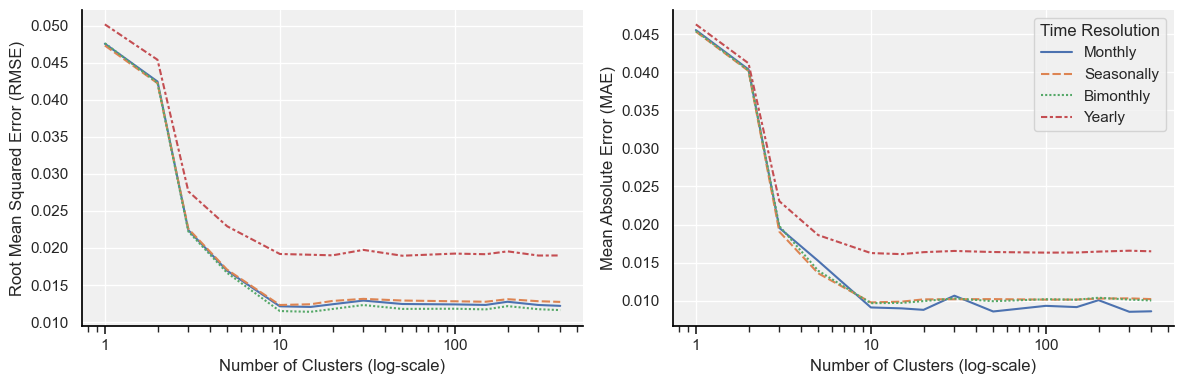

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    x='num_clu',
    y='RMSE',
    hue ="time_res",
    style="time_res",
    data = clus_metrics[(clus_metrics['time_res'] != 'uncorrected')],
    ax = axes[0],
    legend = False
)
axes[0].set_xscale('log')
axes[0].set_ylabel('Root Mean Squared Error (RMSE)')
axes[0].set_xlabel('Number of Clusters (log-scale)')
axes[0].set_xticks([1, 10, 100])
axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

sns.lineplot(
    x='num_clu',
    y='MAE',
    hue = 'time_res',
    style="time_res",
    data = clus_metrics[(clus_metrics['time_res'] != 'uncorrected')],
    ax = axes[1],
    legend = True
)

axes[1].set_xscale('log')
axes[1].set_ylabel('Mean Absolute Error (MAE)')
axes[1].set_xlabel('Number of Clusters (log-scale)')
axes[1].set_xticks([1, 10, 100])
axes[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# fixing the legend labels and sharing it over whole plot.
axes[1].get_legend().remove()
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Monthly', 'Seasonally', 'Bimonthly', 'Yearly'] # renaming labels
plt.legend(handles, labels, ncol=1, loc='upper right', title='Time Resolution')
plt.tight_layout()

In [ ]:
# # ALL FOR MERRA 
# merra_clus_metrics, merra_all_metrics = calc_metrics_merra2()

# # Showing how MAE of different temporal resolutions across all clusters 
# rmse = np.sqrt(merra_all_metrics.groupby(['month', 'time_res'])['se'].mean()).reset_index()
# merra_month_metrics = merra_all_metrics.groupby(['month', 'time_res'])['abs_err'].mean().reset_index()
# merra_month_metrics['RMSE'] = rmse['se']
# merra_month_metrics.columns = ['month', 'time_res', 'MAE', 'RMSE']
# merra_month_metrics.head()

### Exploring Time Resolution

In [8]:
choice = 400 # the number of clusters you would like to analyse
choice2 = 1 # secondary choice for comparison
time_res = 'year' # choose between 'year', 'season', 'two_month', 'month'
metric = 'RMSE' # choose between 'MAE', 'ME', 'RMSE'

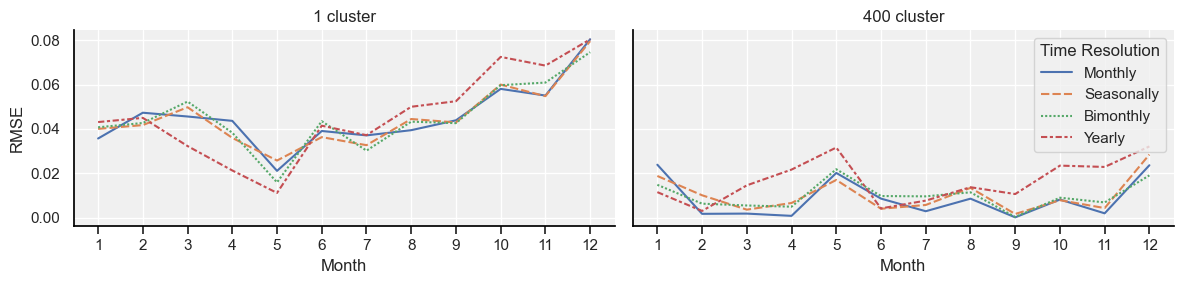

In [58]:
rmse = np.sqrt(all_metrics.groupby(['num_clu', 'month', 'time_res'])['se'].mean()).reset_index()
month_metrics = all_metrics.groupby(['num_clu', 'month', 'time_res'])[['abs_err','diff']].mean().reset_index()
month_metrics['RMSE'] = rmse['se']
month_metrics.columns = ['num_clu','time', 'time_res', 'MAE', 'ME', 'RMSE']

# change signs if you want greater than or fixed choices
# use this if you want a lot of plots
# select_metrics = month_metrics[(month_metrics['num_clu'] == choice) | (month_metrics['num_clu'] == choice2)]

# g = sns.catplot(
#     x='month',
#     y='MAE',
#     hue = 'time_res',
#     hue_order = ['month', 'season', 'two_month', 'year', 'uncorrected'],
#     data = select_metrics,
#     col = 'num_clu',
#     col_wrap = 2,
#     kind = 'point',
#     errorbar = None
# )

# g.set(xlabel='Month', ylabel=metric)
# plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 3),sharey='all')

sns.lineplot(
    x="time",
    y=metric,
    hue = "time_res",
    data = month_metrics[(month_metrics['num_clu'] == choice2)],
    hue_order = ['month', 'season', 'two_month', 'year'],
    style_order=['month', 'season', 'two_month', 'year'],
    style="time_res",
    ax = axes[0],
    legend = False
)



sns.lineplot(
    x="time",
    y=metric,
    hue = "time_res", 
    data = month_metrics[(month_metrics['num_clu'] == choice)],
    hue_order = ['month', 'season', 'two_month', 'year'],
    style_order=['month', 'season', 'two_month', 'year'],
    style="time_res",
    ax = axes[1],
    legend = True
)

axes[0].set_ylabel(metric)
axes[0].set_xlabel('Month')
axes[0].set_xticks(range(1,13))
axes[0].set_title(str(choice2)+" cluster")

axes[1].set_ylabel(metric)
axes[1].set_xlabel('Month')
axes[1].set_xticks(range(1,13))
axes[1].set_title(str(choice)+" cluster")


# fixing the legend labels and sharing it over whole plot.
axes[1].get_legend().remove()
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Monthly', 'Seasonally', 'Bimonthly', 'Yearly'] # renaming labels
plt.legend(handles, labels, ncol=1, loc='upper right', title='Time Resolution')
plt.tight_layout()

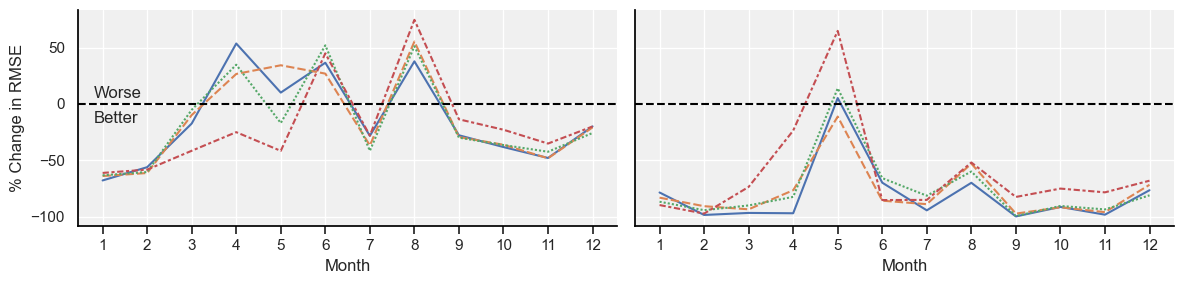

In [64]:
def percent_error_comp(num_clu, metric):
    time_res_list = ['year', 'season', 'two_month', 'month'] 
    df = pd.DataFrame(data = range(1,13), columns = ['time'])
    unc = month_metrics[month_metrics['time_res'] == 'uncorrected' ][metric].reset_index(drop=True)
    
    for time_res in time_res_list:
        cor = month_metrics[(month_metrics['num_clu'] == num_clu) & (month_metrics['time_res'] == time_res) ][metric].reset_index(drop=True)
        df[str(time_res)] = ((cor-unc)/unc)*100

    df = df.melt(id_vars=["time"], # adding in turbine ID for merging
        var_name="time_res", 
        value_name="error")

    return df

fig, axes = plt.subplots(1, 2, figsize=(12, 3),sharey='all')

sns.lineplot(
    x="time",
    y="error",
    hue = "time_res",
    data = percent_error_comp(choice2, metric),
    hue_order = ['month', 'season', 'two_month', 'year'],
    style_order=['month', 'season', 'two_month', 'year'],
    style="time_res",
    ax = axes[0],
    legend = False
)



sns.lineplot(
    x="time",
    y="error",
    hue = "time_res",
    data = percent_error_comp(choice, metric),
    hue_order = ['month', 'season', 'two_month', 'year'],
    style_order=['month', 'season', 'two_month', 'year'],
    style="time_res",
    ax = axes[1],
    legend = True
)

axes[0].set_ylabel('% Change in ' + metric)
axes[0].set_xlabel('Month')
axes[0].set_xticks(range(1,13))

axes[1].set_ylabel('% Change in ' + metric)
axes[1].set_xlabel('Month')
axes[1].set_xticks(range(1,13))

# adding lines
axes[0].axhline(0, ls='--', color='black')
axes[1].axhline(0, ls='--', color='black')
axes[0].text(0.8,5, "Worse")
axes[0].text(0.8,-17, "Better")


# fixing the legend labels and sharing it over whole plot.
axes[1].get_legend().remove()
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Monthly', 'Seasonally', 'Bimonthly', 'Yearly'] # renaming labels
# plt.legend(handles, labels, ncol=1, loc='upper right', title='Time Resolution')
plt.tight_layout()

In [165]:
def mean_month_cf(num_clu, time_res):
    """
    Generate dataframe with observed, uncorrected and selected corrected monthly CFs
    """

    def load_monthly_cf(num_clu, time_res, year_test=2020):
        cor = pd.read_csv('data/results/raw/'+str(year_test)+'_'+time_res+'_'+str(num_clu)+'_cor_cf.csv', parse_dates=['time'])
        cor = cor.melt(id_vars=["time"], # adding in turbine ID for merging
                var_name="ID", 
                value_name="cor")
        cor_month = cor.groupby([pd.Grouper(key='time',freq='M')])['cor'].mean().reset_index()
        return cor_month
        
    cor_month = load_monthly_cf(num_clu, time_res)
    
    unc = pd.read_csv('data/results/raw/'+str(year_test)+'_unc_cf.csv', parse_dates=['time'])
    unc = unc.melt(id_vars=["time"], # adding in turbine ID for merging
        var_name="ID", 
        value_name="unc")
    unc_month = unc.groupby([pd.Grouper(key='time',freq='M')])['unc'].mean().reset_index()
    
    obs = pd.read_csv('data/wind_data/DK/obs_cf_test.csv', parse_dates=['time'])
    obs = obs.melt(id_vars=["time"], # adding in turbine ID for merging
        var_name="ID", 
        value_name="obs")
    obs_month = obs.groupby([pd.Grouper(key='time',freq='M')])['obs'].mean().reset_index()

    cf_month = obs_month.merge(unc_month,on=['time']).merge(cor_month,on=['time'])
    cf_month.columns = ["time", 'Observed', 'Uncorrected', "Corrected"]
    cf_month["time"] = cf_month["time"].dt.month
    cf_month = cf_month.melt(id_vars=["time"],
                var_name="Model", 
                value_name="CF")

    
    return cf_month

cf_month = mean_month_cf(choice, time_res)
cf_month.head()

,time,Model,CF
0,1,Observed,0.398779
1,2,Observed,0.447269
2,3,Observed,0.288087
3,4,Observed,0.242569
4,5,Observed,0.237727


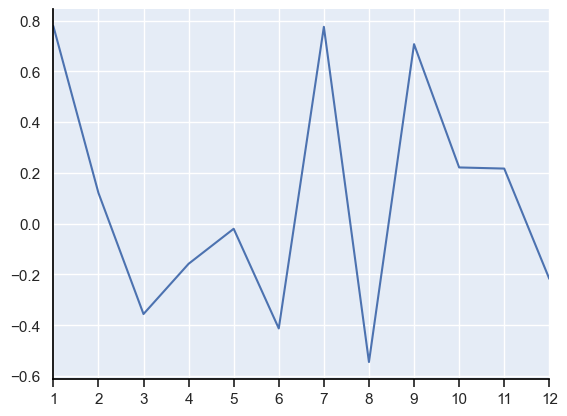

In [163]:
# just random errors to compare to the other temporal stuff to find patters
# # check std vs abs_err 
# plt.scatter(month_metrics[month_metrics["time_res"] == 'month']['abs_err'], month_std['std'])
# plt.xlabel('abs error')
# plt.ylabel('standard deviation')

# check monthly change
# month_cf_obs['change'] = month_cf_obs.cf.diff()
diff = cf_month[cf_month['Model'] == 'Observed']['CF'].diff()/12
# diff = diff.fillna((0.398779-0.224183)/12)
diff2 = diff.diff()/12
perc =cf_month[cf_month['Model'] == 'Observed']['CF'].pct_change()
perc = perc.fillna(((0.398779-0.224183)/0.224183))
# dydx = np.gradient(cf_month[cf_month['Model'] == 'Observed']['CF'].values, range(1,13))
# d2ydx2 = np.gradient(dydx, range(1,13))

# plt.plot(range(1,13),d2ydx2)
# plt.xlim(1, 12)
# plt.xticks(range(1,13))
# plt.show()
plt.plot(range(1,13), perc)
plt.xlim(1, 12)
plt.xticks(range(1,13))
plt.show()

### Exploring Spatial Resolution

In [66]:
turb_info_train = pd.read_csv('data/wind_data/DK/turb_info_train.csv')
turb_info = pd.read_csv('data/wind_data/DK/turb_info_test.csv')

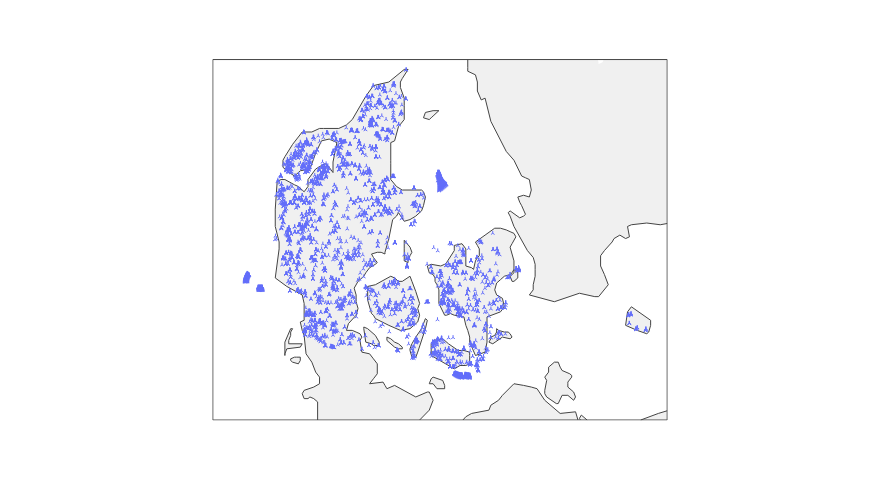

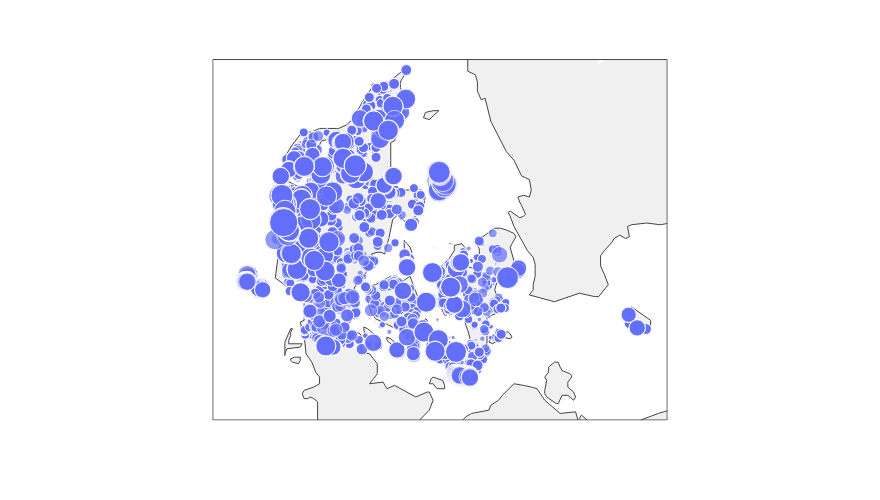

In [68]:
# Plot of where all the turbines used in training are located
fig = px.scatter_geo(
            turb_info_train,
            lat='lat',
            lon='lon',
            )

fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56),
    lataxis_range=[54.8, 58.5], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)

fig.update_traces(marker=dict(size=3, symbol="y-up-open"))
fig.update_layout(width = 600, height = 500)
fig.show()


# Plot of where all the turbines used in training are located with their capacity shown by size
fig = px.scatter_geo(
            turb_info_train,
            lat='lat',
            lon='lon',
            size="capacity", # size of markers, "pop" is one of the columns of gapminder
            
)

fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56),
    lataxis_range=[54.8, 58.5], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_layout(width = 600, height = 500)
fig.show()

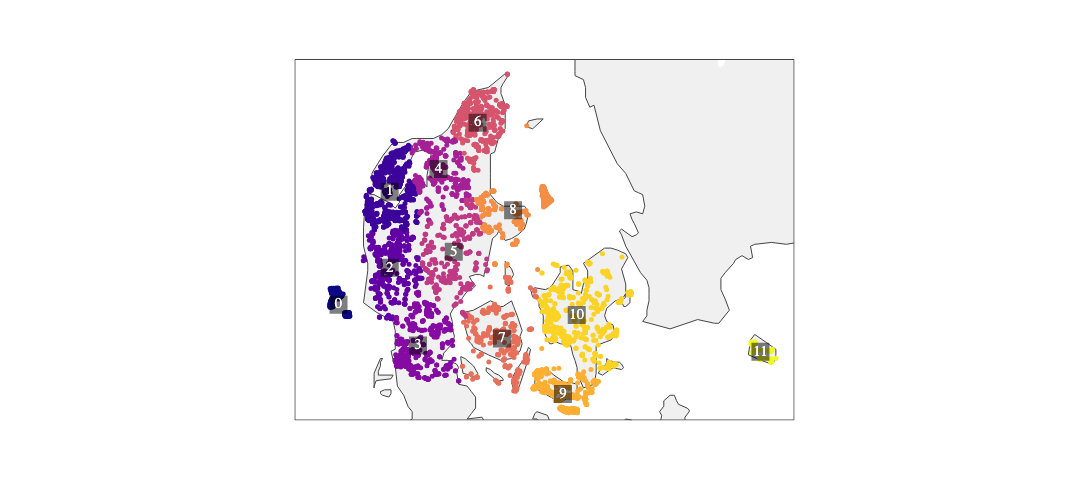

In [83]:
# creating a regional anaylsis

# create kmeans model/object
df = pd.DataFrame(list(zip(turb_info.lat, turb_info.lon)),
               columns =['lat', 'lon'])
kmeans = KMeans(
    init="random",
    n_clusters=12,
    n_init=6,
    max_iter=300,
    random_state=42
)
kmeans.fit(df)

# adding cluster labels to data
labels = kmeans.labels_
turb_info['cluster'] = labels

# order the clusters/labels from left to right
region_test_info = turb_info.groupby('cluster', as_index=False)[['lat','lon']].mean()
region_test_info = region_test_info.sort_values('lon').reset_index(drop=True)
region_test_info['new_idx'] = region_test_info.index
turb_info_idx = turb_info.merge(region_test_info[['cluster','new_idx']], on='cluster',how='left')

# plotting
fig = px.scatter_geo(
    turb_info_idx, 
    lat ='lat',
    lon ='lon', 
    color = 'new_idx',
)

fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(size=5))


fig.add_scattergeo(
    lat = region_test_info['lat'],
    lon = region_test_info['lon'], 
    text = region_test_info['new_idx'],
    mode = 'text + markers',
    textposition = "middle center",
    textfont = dict(
        family = 'Droid Sans Mono',
        size = 15,
        color = "white",
        ),
    marker = dict(
        size=18,
        symbol="square",
        color="black",
        opacity=0.5
        )
    )
fig.update(layout_coloraxis_showscale=False, layout_showlegend=False)

fig.update_layout(width = 600, height = 500)
fig.show()

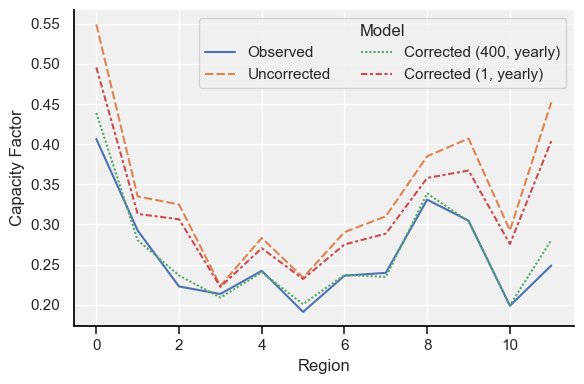

In [91]:
def plot_regional_cf(num_clu, time_res, turb_info):
    # loading files
    obs = pd.read_csv('data/wind_data/DK/obs_cf_test.csv', parse_dates=['time'])
    obs_month = obs.groupby(pd.Grouper(key='time',freq='M')).mean().transpose().reset_index()
    
    unc = pd.read_csv('data/results/raw/'+str(year_test)+'_unc_cf.csv', parse_dates=['time'])
    unc_month = unc.groupby(pd.Grouper(key='time',freq='M')).mean().transpose().reset_index()
    
    def load_monthly_cf(num_clu, time_res, year_test=2020):
        cor = pd.read_csv('data/results/raw/'+str(year_test)+'_'+time_res+'_'+str(num_clu)+'_cor_cf.csv', parse_dates=['time'])
        cor_month = cor.groupby(pd.Grouper(key='time',freq='M')).mean().transpose().reset_index()
        return cor_month
        
    cor_month = load_monthly_cf(num_clu, time_res)
    one_month = load_monthly_cf(1, time_res)  
        

    # adding in turbine ID for merging
    obs_month = obs_month.melt(
        id_vars=["index"],
        var_name="time", 
        value_name="obs"
    )
    
    unc_month = unc_month.melt(
        id_vars=["index"], 
        var_name="time", 
        value_name="unc"
    )
    
    cor_month = cor_month.melt(
        id_vars=["index"],
        var_name="time", 
        value_name="cor"
    )

    one_cor_month = one_month.melt(
        id_vars=["index"],
        var_name="time", 
        value_name="cor_2"
    )

    
    all_cf = obs_month.merge(unc_month,on=['index', 'time']).merge(cor_month,on=['index', 'time']).merge(one_cor_month,on=['index', 'time'])
    all_cf.columns = ["ID", "time", "obs", "unc","cor", "cor_2"]
    all_cf['ID'] = all_cf['ID'].astype('int')
    all_cf = all_cf.merge(turb_info[['ID','lat','lon','cluster','new_idx']],on='ID')

    clus_cf = all_cf.groupby(['cluster', 'new_idx'], as_index=False)[["obs", "unc","cor", "cor_2"]].mean()
    clus_cf = clus_cf.melt(id_vars=['cluster', 'new_idx'],
                    var_name="model", 
                    value_name="cf")

    return all_cf, clus_cf


all_cf, region_cf = plot_regional_cf(choice, time_res, turb_info_idx)


fig, axes = plt.subplots(1, figsize=(6, 4))

sns.lineplot(
    data = region_cf,
    x="new_idx",
    y="cf",
    hue="model",
    style="model",
    legend = True,
    ax = axes
)
# fig, axes = plt.subplots(1, figsize=(6, 4))
axes.set_ylabel('Capacity Factor')
axes.set_xlabel('Region')

# fixing the legend labels and sharing it over whole plot.
axes.get_legend().remove()
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Observed', 'Uncorrected', 'Corrected ('+str(choice)+', '+time_res+'ly)', 'Corrected (1, '+time_res+'ly)'] # renaming labels
plt.legend(handles, labels, ncol=2, loc='upper right', title='Model')
plt.tight_layout()

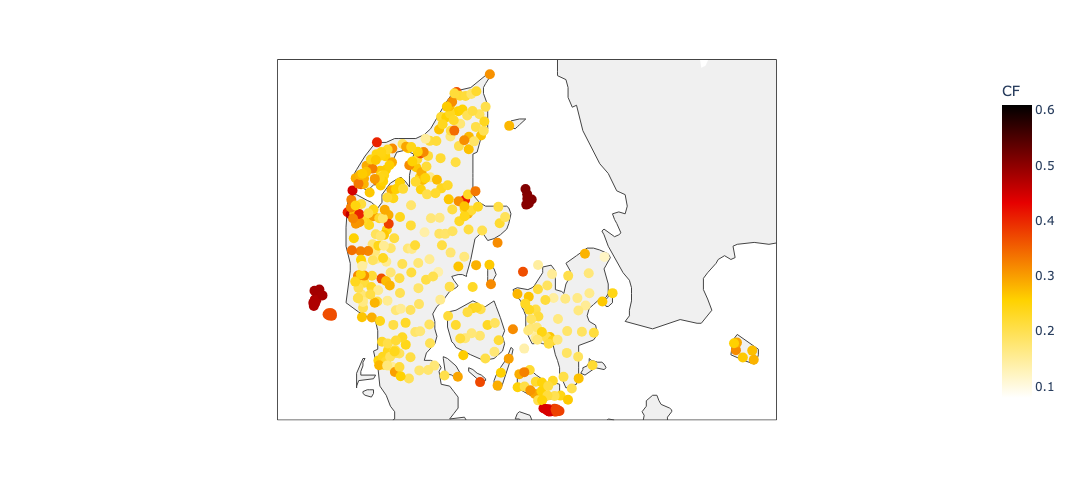

In [126]:
# plotting the generated CF on Denmark

# clustering results for visualiasation
df = pd.DataFrame(list(zip(all_cf.lat, all_cf.lon)),
               columns =['lat', 'lon'])

# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=400,
    n_init=6,
    max_iter=300,
    random_state=42
)
kmeans.fit(df)
labels = kmeans.labels_
all_cf['cluster'] = labels
all_cf = all_cf.groupby(['cluster'], as_index=False)[['lat','lon','obs','cor',
                                                        'unc']].mean()

# plotting
param = 'cor' # CAN ALSO VIEW: 'uncorr', corrected'

fig = px.scatter_geo(
    all_cf,
    lat='lat',
    lon='lon', 
    color = param,
    hover_data=[param],
    facet_col_wrap=3,
    color_continuous_scale='hot_r', 
    range_color=(0.08,0.61)
) 

fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(size=10))
# fig.update_layout(width = 600, height = 500)
fig.update_layout(width = 600, height = 500, 
                  coloraxis_colorbar=dict(
        len=0.93,
        # xanchor="right", x=5,
        # yanchor='middle', y=0.5,
        # thickness=10,
    ))
fig.layout.coloraxis.colorbar.title = 'CF'
fig.show()

### Exploring patterns in the bias-correction factors

In [128]:
factors = pd.read_csv('data/bias_correction/bc_factors_2015-2019_400.csv')
labels = pd.read_csv('data/bias_correction/clus_labels_2015-2019_400.csv')
all_factors = labels.merge(factors[['cluster','scalar','offset', 'month']], on='cluster')
all_factors.head()

,ID,lon,lat,cluster,scalar,offset,month
0,570714700000000027,12.509767,55.636178,213,0.676313,1.7815,1
1,570714700000000027,12.509767,55.636178,213,0.708476,1.7685,2
2,570714700000000027,12.509767,55.636178,213,0.700545,1.7380,3
3,570714700000000027,12.509767,55.636178,213,0.717948,1.6895,4
4,570714700000000027,12.509767,55.636178,213,0.695343,1.7000,5


In [ ]:
# clustering results for visualiasation
df = pd.DataFrame(list(zip(all_factors.lat, all_factors.lon)),
               columns =['lat', 'lon'])

# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=500,
    n_init=6,
    max_iter=300,
    random_state=42
)
kmeans.fit(df)
labels = kmeans.labels_
all_factors['cluster'] = labels
clus_factors = all_factors.groupby(['cluster'], as_index=False)[['lat','lon','scalar','offset']].mean()




# PLOTTING THE 98% PERCENTILE TO SHOW CLEARER TRENDS.
all_factors_filtered = all_factors[(all_factors["scalar"] < all_factors["scalar"].quantile(0.99)) & (all_factors["scalar"] > all_factors["scalar"].quantile(0.01)) & (all_factors["offset"] < all_factors["offset"].quantile(0.99)) & (all_factors["offset"] > all_factors["offset"].quantile(0.01))]

# plotting
fig = px.scatter_geo(
    all_factors_filtered,
    lat='lat',
    lon='lon', 
    color = 'scalar',
    hover_data=['scalar'],
    facet_col_wrap=3,
    color_continuous_scale='viridis', 
    # range_color=(0.6,0.75)
) 

fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(size=10, opacity=0.3))
fig.update_layout(width = 600, height = 500, 
                  coloraxis_colorbar=dict(
        len=0.5,
        xanchor="right", x=5,
        yanchor='bottom', y=0.4,
        thickness=10,
    ))
fig.layout.coloraxis.colorbar.title = 'Scalar'
fig.show()

# plotting
fig = px.scatter_geo(
    all_factors_filtered,
    lat='lat',
    lon='lon', 
    color = 'offset',
    hover_data=['offset'],
    facet_col_wrap=3,
    color_continuous_scale='viridis', 
    # range_color=(1.54,1.95)
) 

fig.update_geos(
    resolution=50, 
    center=dict(lon=11.2, lat=56.2),
    lataxis_range=[54.6, 58], 
    lonaxis_range=[7,15.5],
    projection_type='mercator',
    landcolor=bg_colour
)
fig.update_traces(marker=dict(size=10, opacity=0.3))
fig.update_layout(width = 600, height = 500, 
                  coloraxis_colorbar=dict(
        len=0.5,
        xanchor="right", x=5,
        yanchor='bottom', y=0.4,
        thickness=10,
    ))

fig.layout.coloraxis.colorbar.title = 'Offset'
fig.show()

In [67]:
# PLOTTING THE MONTHLY VARIATION IN BIAS FACTORS

# month_factors = all_factors.groupby(['cluster', 'month'], as_index=False)[['lat','lon','scalar','offset']].mean()


# # plotting
# fig = px.scatter_geo(
#     month_factors,
#     lat='lat',
#     lon='lon', 
#     color = 'scalar',
#     hover_data=['scalar'],
#     facet_col='month',
#     facet_col_wrap=3,
#     color_continuous_scale='viridis', 
# ) 

# fig.update_geos(
#     resolution=50, 
#     center=dict(lon=11.2, lat=56),
#     lataxis_range=[54.8, 58.5], 
#     lonaxis_range=[7,15.5],
#     projection_type='mercator',
# )
# fig.update_traces(marker=dict(size=3.5, opacity=1))
# fig.update_layout(width = 800, height = 800)

# fig.show()


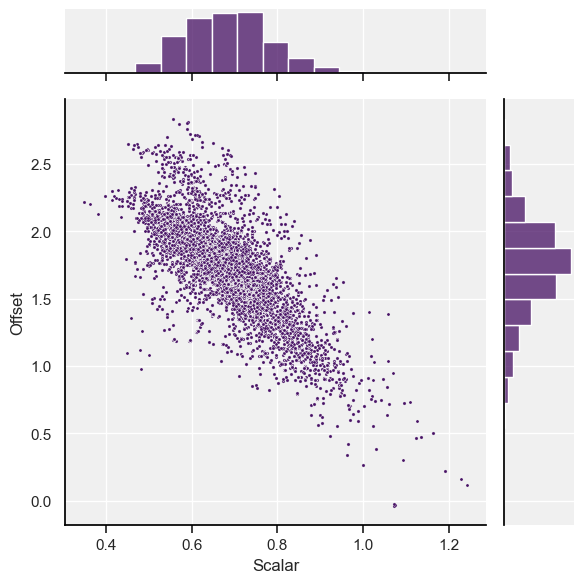

In [152]:
# create kmeans model/object
df = pd.DataFrame(list(zip(all_factors.lat, all_factors.lon)),
               columns =['lat', 'lon'])
kmeans = KMeans(
    init="random",
    n_clusters=5,
    n_init=6,
    max_iter=300,
    random_state=42
)
kmeans.fit(df)

# adding cluster labels to data
labels = kmeans.labels_
all_factors['cluster'] = labels

# order the clusters/labels from left to right
region_train_info = all_factors.groupby('cluster', as_index=False)[['lat','lon']].mean()
region_train_info = region_train_info.sort_values('lon').reset_index(drop=True)
region_train_info['new_idx'] = region_train_info.index
all_factors_idx = all_factors.merge(region_train_info[['cluster','new_idx']], on='cluster',how='left')



g = sns.jointplot(
    x="scalar",
    y="offset",
    data=all_factors_idx,
    s=5,
    marginal_kws=dict(bins=15),
    color='#471164FF',

)
plt.ylabel('Offset')
plt.xlabel('Scalar')
plt.tight_layout()

### Extra Old Functions

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

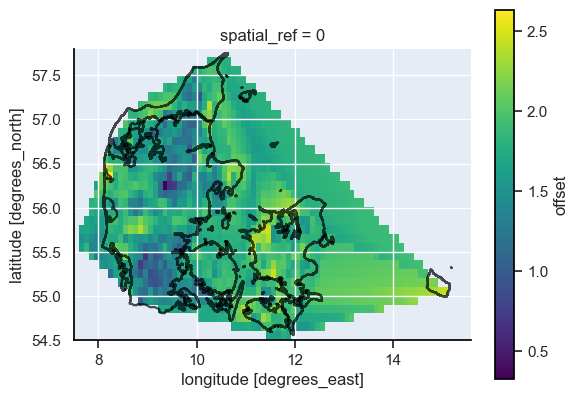

In [176]:
## INTERPOLATING THE SCALAR AND OFFSET TO SHOW SPATIAL PATTERNS THIS WILL BE USEFUL FOR OTEHR STUF



from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata
from functools import partial

gdf = gpd.GeoDataFrame(
    all_factors, geometry=gpd.points_from_xy(all_factors['lon'], all_factors['lat']), crs="EPSG:4326",
)

denmark = gpd.read_file("data/wind_data/DK/shape/DNK_adm0.shp")

geo_grid_cubic = make_geocube(
    gdf,
    measurements=["scalar", "offset"],
    resolution=(0.1, 0.1),
    rasterize_function=partial(rasterize_points_griddata, method="linear"),
    interpolate_na_method="nearest",
)


fig, ax = plt.subplots()

geo_grid_cubic.scalar.plot.imshow()

denmark.boundary.plot(
    ax=ax,
    alpha=0.7,
    color="black"
)

ax.set_axis_off()


fig, ax = plt.subplots()

geo_grid_cubic.offset.plot.imshow()

denmark.boundary.plot(
    ax=ax,
    alpha=0.7,
    color="black"
)

# ax.set_axis_off()

In [14]:
# comparing capacities with desired choice of run, ideally for these plots choose the one that showed best rmse and mae


def mean_month_cf(num_clu, time_res, plot=False):

    def load_monthly_cf(num_clu, time_res, year_test=2020):
        cor = pd.read_csv('data/results/raw/'+str(year_test)+'_'+time_res+'_'+str(num_clu)+'_cor_cf.csv', parse_dates=['time'])
        cor_month = cor.groupby(pd.Grouper(key='time',freq='M')).mean().transpose().mean().values
        return cor_month
    cor_month = load_monthly_cf(num_clu, time_res)
    
    unc = pd.read_csv('data/results/raw/'+str(year_test)+'_unc_cf.csv', parse_dates=['time'])
    unc_month = unc.groupby(pd.Grouper(key='time',freq='M')).mean().transpose().mean().values
    
    obs = pd.read_csv('data/wind_data/DK/obs_cf_test.csv', parse_dates=['time'])
    obs_month = obs.groupby(pd.Grouper(key='time',freq='M')).mean().transpose().mean().values
    
    
    if plot == True:
        cor_monthly = load_monthly_cf(num_clu, "month")
        cor_bimonthly = load_monthly_cf(num_clu, "two_month")
        cor_seasonly = load_monthly_cf(num_clu, "season")
        cor_yearly = load_monthly_cf(num_clu, "year")
    
    
        plt.plot(range(1,13), obs_month*100, label='Observation')
        # plt.plot(range(1,13), unc_month*100, label='Uncorrected')
        plt.plot(range(1,13), cor_monthly*100, label='Monthly')
        plt.plot(range(1,13), cor_bimonthly*100, label='Bi-Monthly')
        plt.plot(range(1,13), cor_seasonly*100, label='Seasonly')
        plt.plot(range(1,13), cor_yearly*100, label='Yearly')
        
        
        plt.xlabel('Month')
        plt.ylabel('Capacity Factor %')
        plt.legend()

    return 

mean_month_cf(1, 'month')



def plot_regional_cf(num_clu, time_res, turb_info):
    # loading files
    obs = pd.read_csv('data/wind_data/DK/obs_cf_test.csv', parse_dates=['time'])
    obs_month = obs.groupby(pd.Grouper(key='time',freq='M')).mean().transpose().reset_index()
    
    unc = pd.read_csv('data/results/raw/'+str(year_test)+'_unc_cf.csv', parse_dates=['time'])
    unc_month = unc.groupby(pd.Grouper(key='time',freq='M')).mean().transpose().reset_index()
    
    def load_monthly_cf(num_clu, time_res, year_test=2020):
        cor = pd.read_csv('data/results/raw/'+str(year_test)+'_'+time_res+'_'+str(num_clu)+'_cor_cf.csv', parse_dates=['time'])
        cor_month = cor.groupby(pd.Grouper(key='time',freq='M')).mean().transpose().reset_index()
        return cor_month
        
    cor_month = load_monthly_cf(num_clu, time_res)
    one_month = load_monthly_cf(1, time_res)  
        

    # adding in turbine ID for merging
    obs_month = obs_month.melt(id_vars=["index"],
                var_name="time", 
                value_name="obs")
    unc_month = unc_month.melt(id_vars=["index"], 
                var_name="time", 
                value_name="unc")
    cor_month = cor_month.melt(id_vars=["index"],
                    var_name="time", 
                    value_name= str(num_clu) + " Cluster")

    one_cor_month = one_month.melt(id_vars=["index"],
                    var_name="time", 
                    value_name="1 Cluster")

    
    all_cf = obs_month.merge(unc_month,on=['index', 'time']).merge(cor_month,on=['index', 'time']).merge(one_cor_month,on=['index', 'time'])
    all_cf.columns = ["ID", "time", 'Observed', 'Uncorrected',(str(num_clu) + " Cluster"), "1 Cluster"]
    all_cf['ID'] = all_cf['ID'].astype('int')
    all_cf = all_cf.merge(turb_info[['ID','lat','lon','cluster','new_idx']],on='ID')

    clus_cf = all_cf.groupby(['cluster', 'new_idx'], as_index=False)[['Observed', 'Uncorrected',(str(num_clu) + " Cluster"), "1 Cluster"]].mean()
    clus_cf = clus_cf.melt(id_vars=['cluster', 'new_idx'],
                    var_name="Model", 
                    value_name="cf")

    return all_cf, clus_cf

         time  570714700000000027  570714700000000034  570714700000000041   
0  2020-01-31            0.198190            0.198190            0.209922  \
1  2020-02-29            0.315300            0.315300            0.335098   
2  2020-03-31            0.202551            0.202551            0.218553   
3  2020-04-30            0.162531            0.162531            0.199488   
4  2020-05-31            0.125030            0.125030            0.151492   
5  2020-06-30            0.108265            0.108265            0.086822   
6  2020-07-31            0.139188            0.139188            0.134599   
7  2020-08-31            0.054671            0.054671            0.059863   
8  2020-09-30            0.082833            0.082833            0.102484   
9  2020-10-31            0.189068            0.189068            0.164940   
10 2020-11-30            0.193593            0.193593            0.159361   
11 2020-12-31            0.236290            0.236290            0.229617   

,time,570714700000000027,570714700000000034,570714700000000041,570714700000000058,570714700000000065,570714700000000140,570714700000000157,570714700000000171,570714700000000188,...,571313174001698699,571313174001699887,571313174001699894,571313174001699900,571313174001764448,571313174116016241,571313174116025533,571313174116253585,571313174116620486,571313174116625801
0,2020-01-31,0.198190,0.198190,0.209922,0.209922,0.209922,0.319314,0.267245,0.206523,0.206523,...,0.669458,0.663967,0.608447,0.654053,0.052019,0.100806,0.043871,0.140169,0.116398,0.123871
1,2020-02-29,0.315300,0.315300,0.335098,0.335098,0.335098,0.428570,0.410478,0.330632,0.330632,...,0.678438,0.721530,0.577626,0.692855,0.170287,0.182184,0.087644,0.411876,0.206897,0.298966
2,2020-03-31,0.202551,0.202551,0.218553,0.218553,0.218553,0.264229,0.252770,0.163163,0.163163,...,0.466229,0.492542,0.402368,0.446231,0.067569,0.093817,0.047204,0.214386,0.092043,0.060914
3,2020-04-30,0.162531,0.162531,0.199488,0.199488,0.199488,0.064228,0.204851,0.169208,0.169208,...,0.334828,0.336588,0.306583,0.356468,0.092870,0.087639,0.073167,0.242095,0.129444,0.041056
4,2020-05-31,0.125030,0.125030,0.151492,0.151492,0.151492,0.141184,0.150886,0.123674,0.123674,...,0.285669,0.331669,0.331274,0.382193,0.060908,0.061022,0.049247,0.228767,0.109086,0.103441
5,2020-06-30,0.108265,0.108265,0.086822,0.086822,0.086822,0.161648,0.150936,0.085713,0.085713,...,0.250741,0.257731,0.237406,0.252273,0.039698,0.051250,0.021222,0.108078,0.053056,0.080389
6,2020-07-31,0.139188,0.139188,0.134599,0.134599,0.134599,0.181494,0.186954,0.125233,0.125233,...,0.284246,0.292264,0.282921,0.332273,0.061714,0.073656,0.029409,0.192166,0.132097,0.122419
7,2020-08-31,0.054671,0.054671,0.059863,0.059863,0.059863,0.083561,0.075332,0.043580,0.043580,...,0.201845,0.229597,0.187877,0.208860,0.016529,0.026344,0.003333,0.073237,0.024892,0.033441
8,2020-09-30,0.082833,0.082833,0.102484,0.102484,0.102484,0.149606,0.125549,0.084912,0.084912,...,0.236174,0.265608,0.236403,0.280377,0.020679,0.042917,0.015833,0.118516,0.041667,0.066111
9,2020-10-31,0.189068,0.189068,0.164940,0.164940,0.164940,0.291223,0.239824,0.098737,0.098737,...,0.449114,0.482739,0.446064,0.471565,0.048423,0.073522,0.029946,0.135134,0.052742,0.120376


<Axes: >

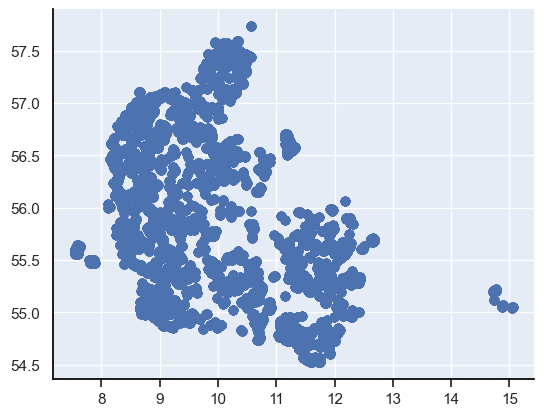

In [86]:
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# this is to plot on a map with geopandas to remove the lag that plotly causes
# loading files and creating points

denmark = gpd.read_file("data/wind_data/DK/shape/DNK_adm0.shp")
geo_cf = gpd.GeoDataFrame(
    all_factors, geometry=gpd.points_from_xy(all_factors['lon'], all_factors['lat']), crs="EPSG:4326",
)

geo_cf.plot()


# # plotting
# fig, ax = plt.subplots(1,3,figsize=(15, 5))

# for row in ax:
#     denmark.plot(
#         ax=row, 
#         alpha=0.7,
#         color="pink"
# )

# geo_cf.plot(
#     ax=ax[0], 
#     column='unc', 
#     cmap='hot', 
#     legend=True,
#     cax=cax,
# )

# geo_cf.plot(
#     ax=ax[1], 
#     column='cor', 
#     cmap='hot', 
#     legend=True,
#     cax=cax,
# )

# geo_cf.plot(
#     ax=ax[2], 
#     column='obs', 
#     cmap='hot', 
#     legend=True,
#     cax=cax,
# )

# plt.show()

STUFF BELOW IS WHAT MADE ME ANGRY WHEN I WAS TRYING TO SHOW THE IMPACTS OF THE TEMPORAL STUFF

In [72]:
# # importing observation for denmark 2020.
# turb_info = pd.read_csv('data/wind_data/DK/turb_info_test.csv')

# # forming clusters
# df = pd.DataFrame(list(zip(turb_info.lat, turb_info.lon)), 
#                columns =['lat', 'lon'])
# # create kmeans model/object
# kmeans = KMeans(
#     init="random",
#     n_clusters=10,
#     n_init=6,
#     max_iter=300,
#     random_state=42
# )

# kmeans.fit(df)
# turb_info['cluster'] = kmeans.labels_

# cf_obs = pd.read_csv('data/wind_data/DK/obs_cf_test.csv', parse_dates=['time'])
# cf_obs = cf_obs.melt(id_vars=["time"], # adding in turbine ID for merging
#                 var_name="ID", 
#                 value_name="cf")
# cf_obs['ID'] = cf_obs['ID'].astype('int')
# cf_obs = cf_obs.merge(turb_info[['ID','cluster']],on='ID').reset_index(drop=True)

# cf_obs['counts'] = cf_obs['cluster'].map(cf_obs['cluster'].value_counts())

# # clus_cf_obs = cf_obs.groupby([pd.Grouper(key='time',freq='M'), 'cluster']).agg({'cf':'sum','counts':'mean'}).reset_index()
# # clus_cf_obs['cf'] = clus_cf_obs['cf']/(clus_cf_obs['counts']/12)

# clus_cf_obs = cf_obs.groupby([pd.Grouper(key='time',freq='M'), 'cluster','ID'])['cf'].mean().reset_index()

# clus_cf_obs = clus_cf_obs.sort_values(['time','cluster']).reset_index(drop=True)
# num_clu = 400

# cluster_all = []
# abs_diff_calc = []
# time_all = []
# month_all = []
# id_all = []

# for time_res in time_res_list:
#     cf_cor = pd.read_csv('data/results/raw/'+str(year_test)+'_'+time_res+'_'+str(num_clu)+'_cor_cf.csv', parse_dates=['time'])
#     cf_cor = cf_cor.melt(id_vars=["time"], # adding in turbine ID for merging
#                     var_name="ID", 
#                     value_name="cf")
#     cf_cor['ID'] = cf_cor['ID'].astype('int')
#     cf_cor = cf_cor.merge(turb_info[['ID','cluster']],on='ID').reset_index(drop=True)

#     # cf_cor['counts'] = cf_cor['cluster'].map(cf_cor['cluster'].value_counts())
#     # clus_cf_cor = cf_cor.groupby([pd.Grouper(key='time',freq='M'), 'cluster']).agg({'cf':'sum','counts':'mean'}).reset_index()
#     # clus_cf_cor['cf'] = clus_cf_cor['cf']/(clus_cf_cor['counts']/12)
    
#     clus_cf_cor = cf_cor.groupby([pd.Grouper(key='time',freq='M'), 'cluster', 'ID'])['cf'].mean().reset_index()
    
#     clus_cf_cor = clus_cf_cor.sort_values(['time','cluster']).reset_index(drop=True)
#     abs_diff = clus_cf_obs.cf.values - clus_cf_cor.cf.values
    
#     abs_diff_calc.append(abs_diff)
#     time_all.append([time_res]*len(abs_diff))
#     month_all.append(clus_cf_cor.time.values)
#     cluster_all.append(clus_cf_cor.cluster.values)
#     id_all = [clus_cf_cor.cluster.values]

# df_clus_cor = pd.DataFrame(list(zip(np.ravel(cluster_all), np.ravel(time_all), np.ravel(month_all), np.ravel(abs_diff_calc))), 
#              columns =['cluster', 'time_res', 'month', 'abs_err'])   

# df_clus_cor['se'] = df_clus_cor['abs_err']**2
# df_clus_cor_res = df_clus_cor


# # rmse = np.sqrt(df_clus_cor_res.groupby(['time_res', 'month'])['se'].mean()).reset_index()
# # df_clus_cor_res = df_clus_cor_res.groupby(['time_res', 'month'])['abs_err'].mean().reset_index()
# # df_clus_cor_res['RMSE'] = rmse['se']
# # df_clus_cor_res
# # df_clus_cor.columns = ['cluster', 'time_res', 'MAE', 'RMSE']

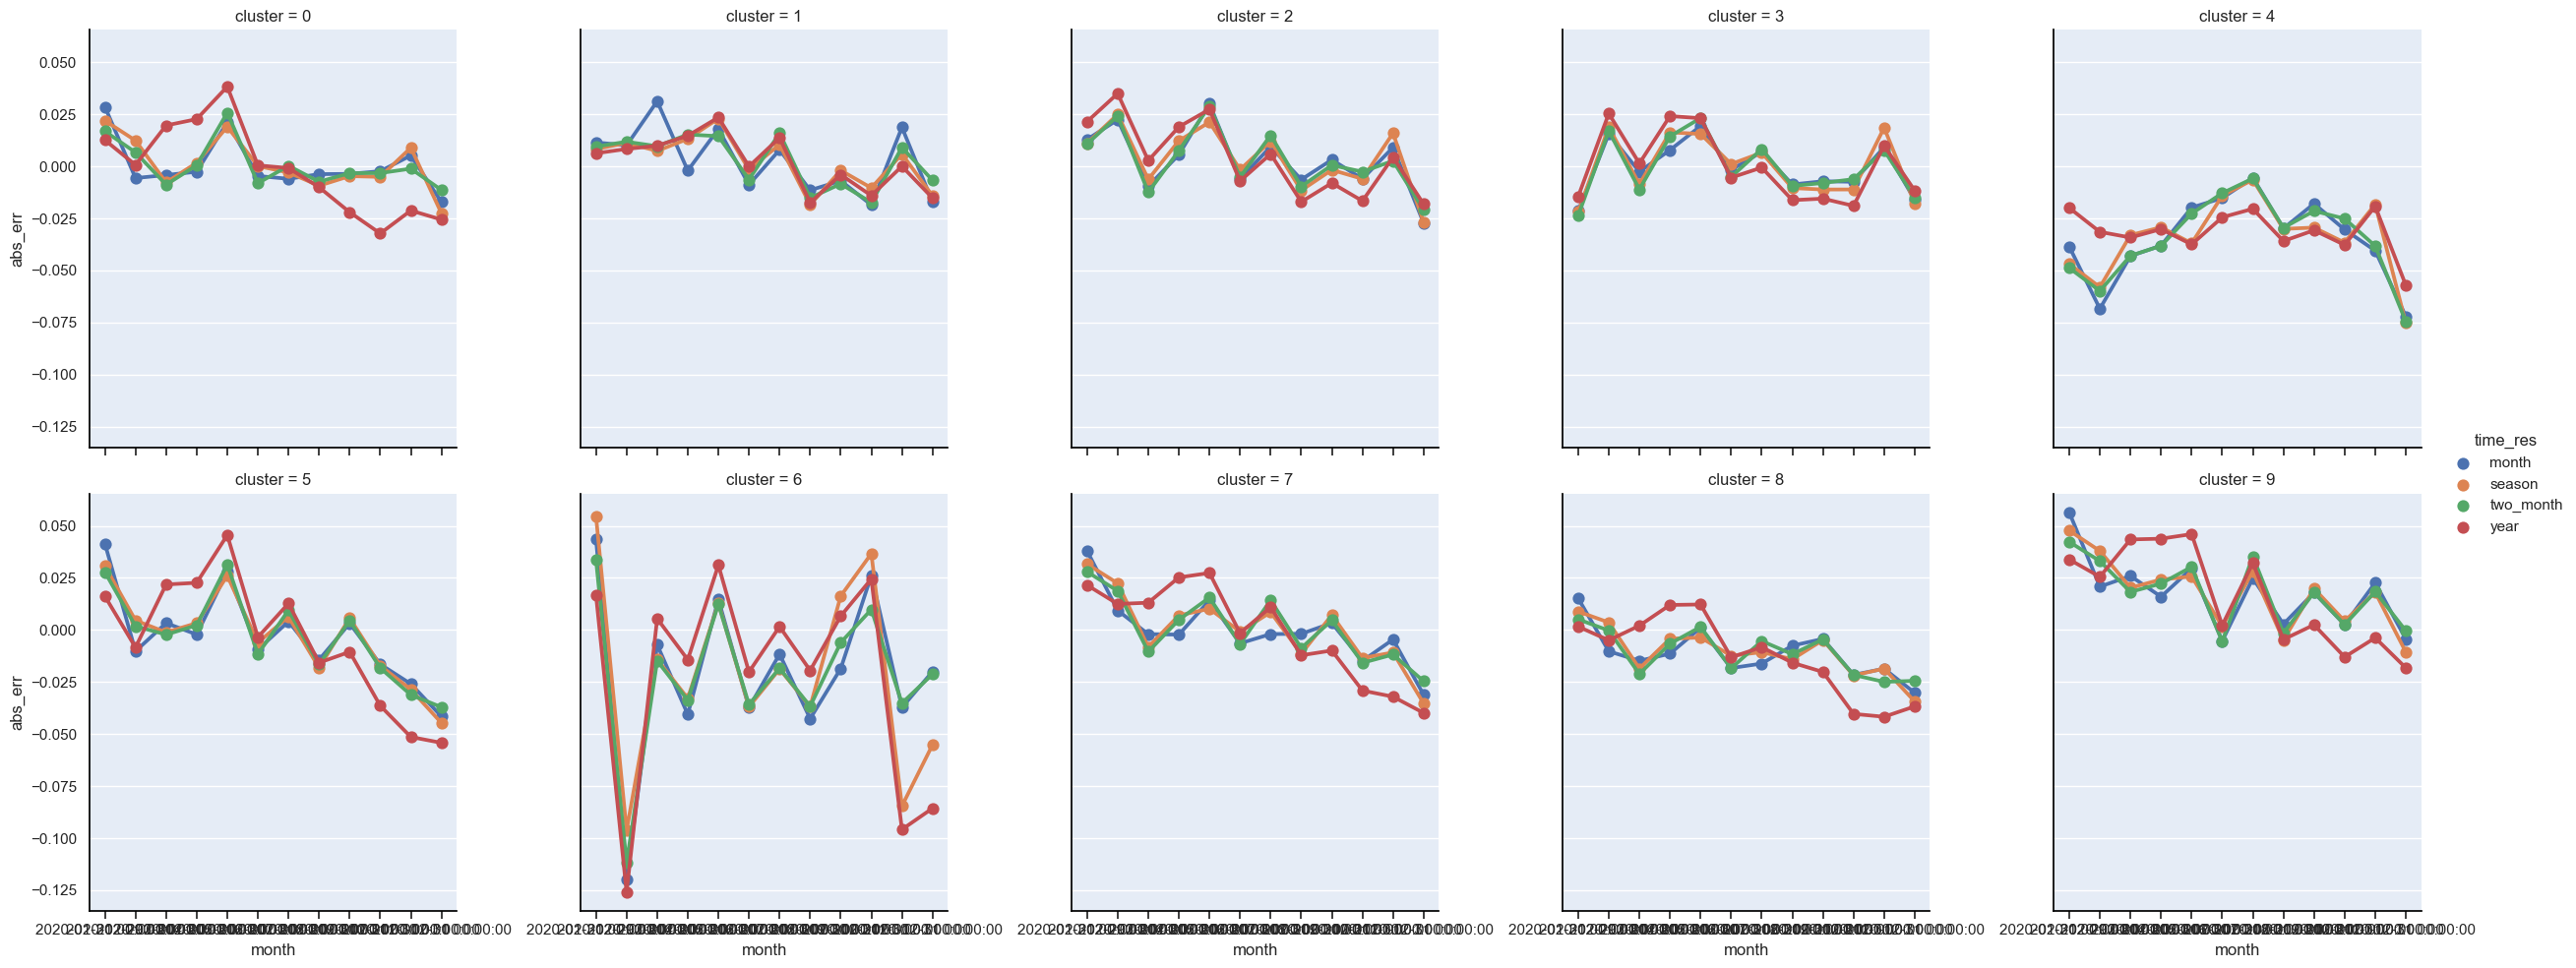

In [73]:
# g = sns.catplot(
#     x='month',
#     y='abs_err',
#     hue = 'time_res',
#     hue_order = ['month', 'season', 'two_month', 'year'],
#     data = df_clus_cor,
#     col = 'cluster',
#     col_wrap = 5,
#     kind = 'point',
#     errorbar = None
# )

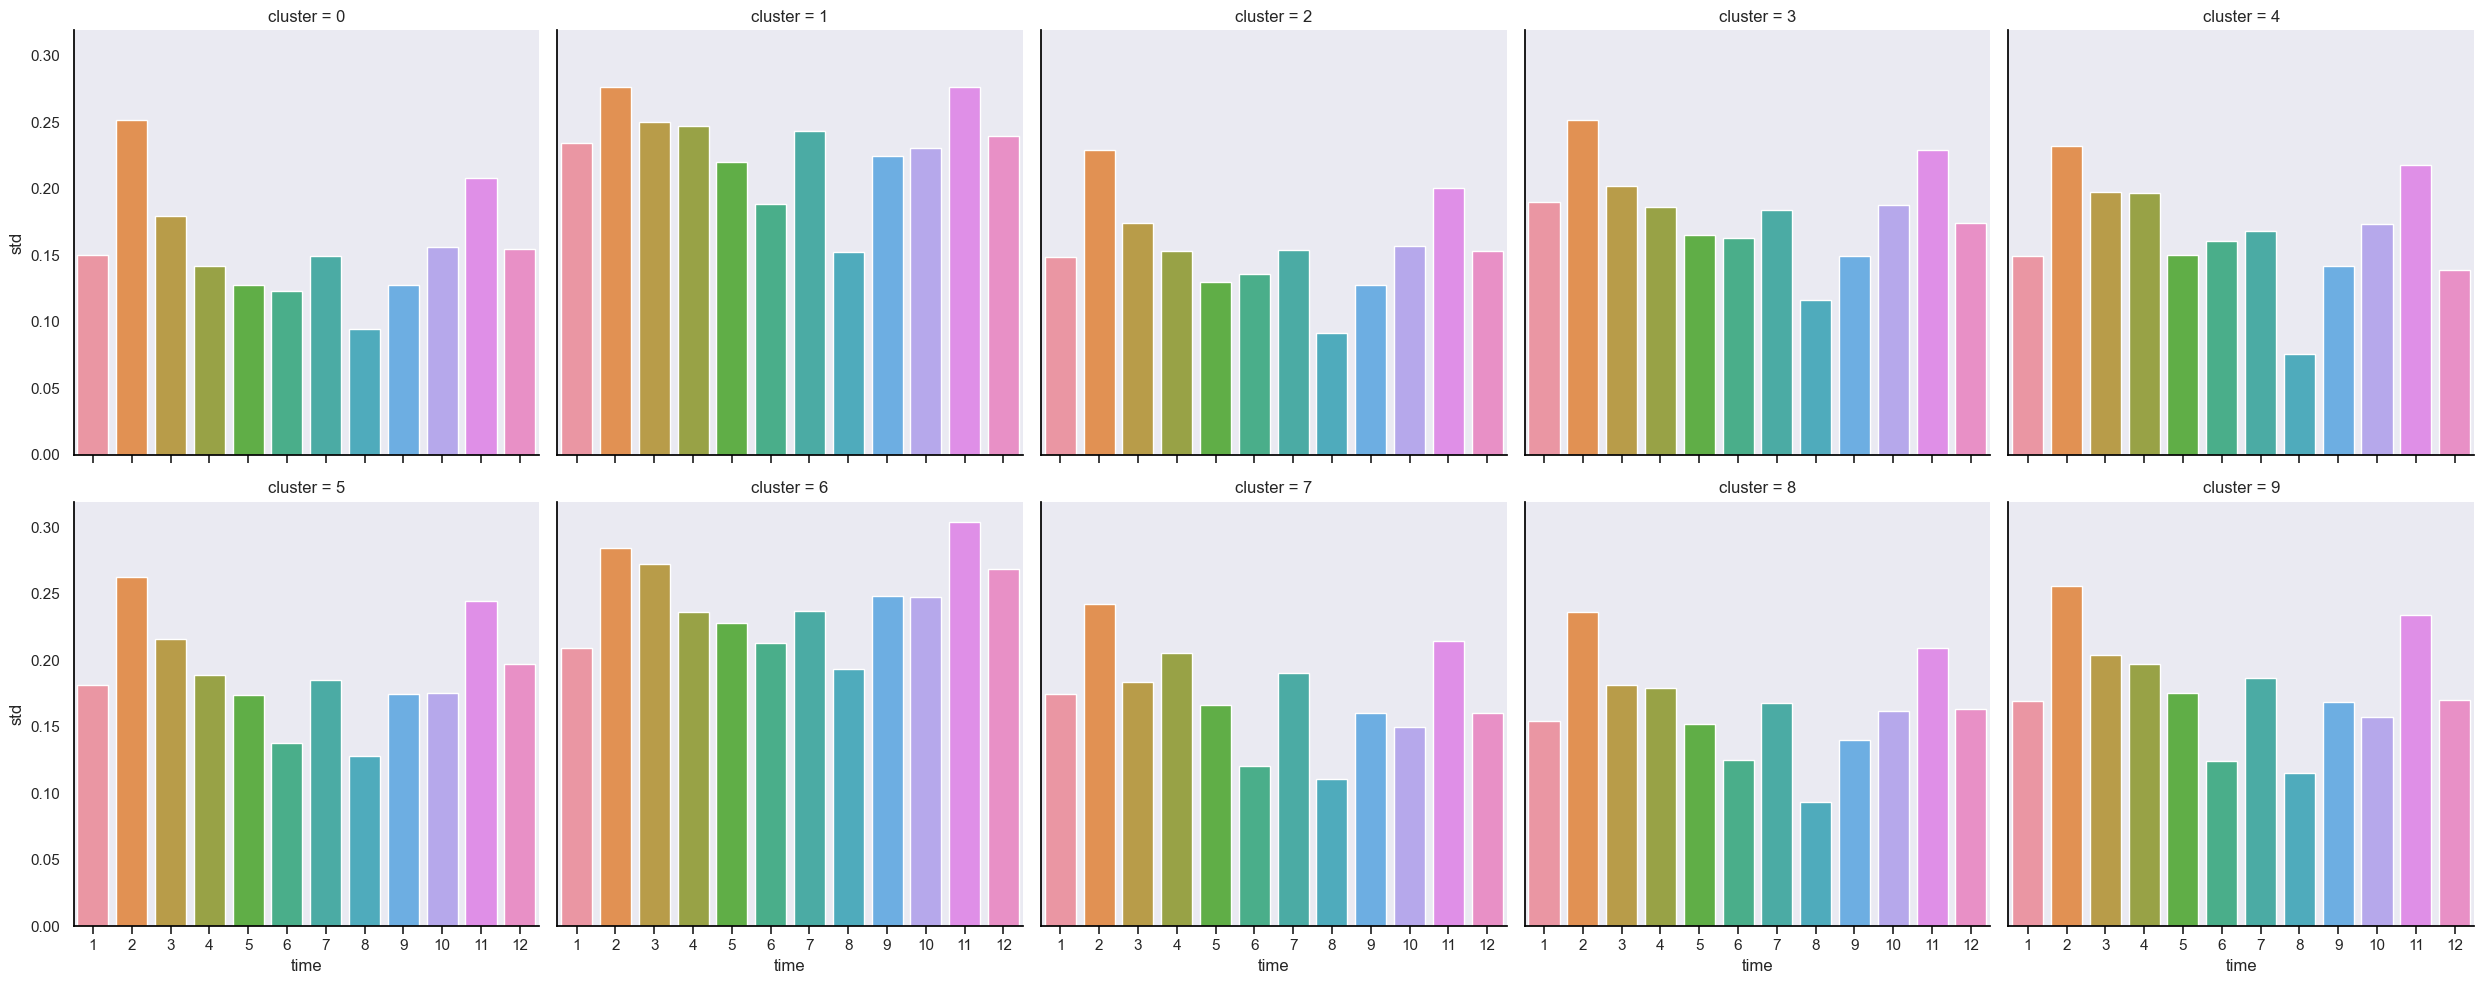

In [323]:
# cf_cor = pd.read_csv('data/results/raw/'+str(year_test)+'_'+'year'+'_'+str(300)+'_cor_cf.csv', parse_dates=['time'])
# cf_cor = cf_cor.melt(id_vars=["time"], # adding in turbine ID for merging
#                 var_name="ID", 
#                 value_name="cf")
# cf_cor['ID'] = cf_cor['ID'].astype('int')
# cf_cor = cf_cor.merge(turb_info[['ID','cluster']],on='ID').reset_index(drop=True)

# # cf_cor['counts'] = cf_cor['cluster'].map(cf_cor['cluster'].value_counts())
# # clus_cf_cor = cf_cor.groupby([pd.Grouper(key='time',freq='M'), 'cluster']).agg({'cf':'sum','counts':'mean'}).reset_index()
# # clus_cf_cor['cf'] = clus_cf_cor['cf']/(clus_cf_cor['counts']/12)

# cor_cf_std = cf_cor.groupby([pd.Grouper(key='time',freq='M'), 'cluster'])['cf'].agg(["std"]).reset_index()
# cor_cf_std = cor_cf_std.sort_values(['time','cluster']).reset_index(drop=True)
# cor_cf_std["time"] = cor_cf_std["time"].dt.month

# g = sns.catplot(
#     x='time',
#     y='std',
#     data = cor_cf_std,
#     col = 'cluster',
#     col_wrap = 5,
#     kind = 'bar',
#     errorbar = None,
#     legend_out = False,
# )